## Stage 1: Exploratory Data Analysis

# Setup & Data Loading

In [588]:
# Import needed packages
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import skew, kurtosis

In [589]:
# Load the preprocessed data
cleaned_data = pd.read_csv('../data/checkpoints/enriched_cleaned_data.csv', delimiter = '|')

In [590]:
# Set the theme and figisze for a unique plot appearence
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Data Preparation & simple Feature Engineering

As a preperation step, the tokenzied words are converted to lists so later operations work as expected. In addition the datatype for "date" is set to datetime and year / month as single values are derived to aggregate later on these values. Also the word counts for the tokenized words and sentences are introduced as simple features for later analysis.

In [591]:
# Define a function to convert a string representation of a list to a list datatype
def string_to_list(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        print('List conversion failed')
        return []

# Convert the string representations of the lists to the correct 'list' datatype
cleaned_data['word_tokens'] = cleaned_data['word_tokens'].apply(string_to_list)
cleaned_data['sentence_tokens'] = cleaned_data['sentence_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_word_tokens'] = cleaned_data['pos_tagged_word_tokens'].apply(string_to_list)
cleaned_data['pos_tagged_sentence_tokens'] = cleaned_data['pos_tagged_sentence_tokens'].apply(string_to_list)
cleaned_data['esg_topics'] = cleaned_data['esg_topics'].apply(string_to_list)

In [592]:
# Add some count features for the analysis
cleaned_data['cnt_word'] = cleaned_data['word_tokens'].apply(len)
cleaned_data['cnt_sentence'] = cleaned_data['sentence_tokens'].apply(len)
cleaned_data['cnt_esg'] = cleaned_data['esg_topics'].apply(len)

# Calculate ratio between words/sentences
cleaned_data['ratio_word_sentence'] = cleaned_data['cnt_word'] / cleaned_data['cnt_sentence']

In [593]:
# Convert date to correct datatype
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Derive year and month to aggregate
cleaned_data['year_month'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y-%m'))
cleaned_data['year'] = cleaned_data['date'].apply(lambda x: x.strftime('%Y'))
cleaned_data['month'] = cleaned_data['date'].apply(lambda x: x.strftime('%m'))

In [599]:
# Check the data with a few samples
cleaned_data.sample(5)

company  datatype       date          domain   
9461   Siemens Energy   general 2022-09-08     energyvoice  \
1886              BMW      tech 2021-07-27  digitaljournal   
10423      Volkswagen  business 2022-08-16  marketscreener   
5405           E ONSE   general 2023-03-03   financialpost   
8669        Sartorius  business 2022-07-19  investmentweek   

                                              esg_topics  internal symbol   
9461                       [WindEnergy, RenewableEnergy]         0    ENR  \
1886   [GenderDiversity, Biodiversity, RussianFederat...         0    BMW   
10423                        [Fraud, Social, Corruption]         0   VOW3   
5405           [NaturalGas, RussianFederation, Sanction]         0   EOAN   
8669                                   [CustomerService]         0    SRT   

                                                   title   
9461   GE blocked from selling huge offshore turbine ...  \
1886   Osaka crashes out of Olympics as Bermuda celeb...   
10423  Lula, Bolsonaro officially enter campaign seas...   
5405   Russia set to seal up damaged Nord Stream gas ...   
8669   Blue Whale backs investment process amid 30% t...   

                                         cleaned_content   
9461   offshore wind turbine dealing fresh blow congl...  \
1886   hi looking japanese star crashed tennis compet...   
10423  term president country jailed corruption convi...   
5405   moscowfrankfurt russia ruptured undersea nord ...   
8669   already account please use link sign problem a...   

                                             word_tokens  ...   
9461   [offshore, wind, turbine, dealing, fresh, blow...  ...  \
1886   [hi, looking, japanese, star, crashed, tennis,...  ...   
10423  [term, president, country, jailed, corruption,...  ...   
5405   [moscowfrankfurt, russia, ruptured, undersea, ...  ...   
8669   [already, account, please, use, link, sign, pr...  ...   

                       sector                               industry   
9461                Utilities  Utilities—Independent Power Producers  \
1886   Consumer Discretionary                     Auto Manufacturers   
10423  Consumer Discretionary                     Auto Manufacturers   
5405                Utilities                  Utilities—Diversified   
8669               Healthcare         Medical Instruments & Supplies   

      sentiment_value  cnt_word cnt_sentence cnt_esg  ratio_word_sentence   
9461         0.187590       155           10       2            15.500000  \
1886         0.184056       444           36       3            12.333333   
10423       -0.082653       209           15       3            13.933333   
5405         0.122587       481           40       3            12.025000   
8669         0.187904       300           24       1            12.500000   

       year_month  year  month  
9461      2022-09  2022     09  
1886      2021-07  2021     07  
10423     2022-08  2022     08  
5405      2023-03  2023     03  
8669      2022-07  2022     07  

[5 rows x 24 columns]

# General Descriptive Analysis

To get a fast overview in terms of the statistial key metrics, several functions are defined. These ensure quick insights into the data.

In [595]:
def plot_basic_hist_and_box(column, data):
    """
    Plots a histogram and boxplot of a specified column in a pandas DataFrame.

    Args:
    - column (str): The name of the column to plot.
    - data (pandas DataFrame): The DataFrame containing the column.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

def calculate_basic_statistical_properties(column, data):
    """
    Calculates basic statistical properties of a specified column in a pandas DataFrame.

    Args:
    - column (str): The name of the column to analyze.
    - data (pandas DataFrame): The DataFrame containing the column.

    Returns:
    - None
    """
    mean = data[column].mean()
    median = data[column].median()
    mode = data[column].mode().values[0]
    skewness = skew(data[column].dropna())
    kurt = kurtosis(data[column].dropna())
    
    print(f'Mean: {round(mean,2)}\nMedian: {round(median,2)}\nMode: {round(mode,2)}\nSkewness: {round(skewness,2)}\nKurtosis: {round(kurt,2)}')

def calulate_dispersion_measures(column, data):
    """
    Calculates measures of dispersion of a specified column in a pandas DataFrame.

    Args:
    - column (str): The name of the column to analyze.
    - data (pandas DataFrame): The DataFrame containing the column.

    Returns:
    - None
    """
    min_value = data[column].min()
    max_value = data[column].max()
    range_value = max_value - min_value
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    variance = data[column].var()
    std_dev = data[column].std()
    
    print(f'Range: {round(range_value,2)}\nInterquartile Range: {round(iqr,2)}\nVariance: {round(variance,2)}\nStandard Deviation: {round(std_dev,2)}')

### Basic Statistical Metrics of documents by Words

Mean: 913.31
Median: 329.0
Mode: 257
Skewness: 13.84
Kurtosis: 226.53
Range: 122419
Interquartile Range: 329.0
Variance: 22806456.23
Standard Deviation: 4775.61


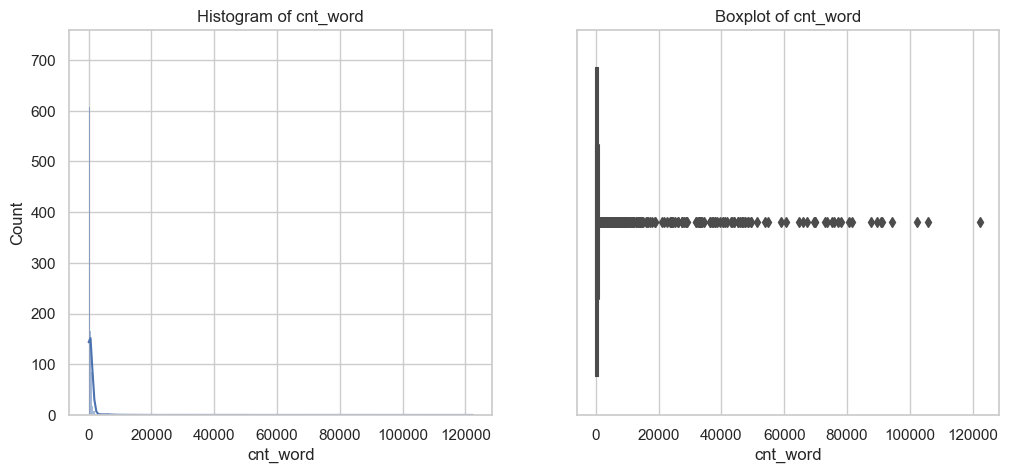

In [562]:
calculate_basic_statistical_properties('cnt_word', cleaned_data)
calulate_dispersion_measures('cnt_word', cleaned_data)
plot_basic_hist_and_box('cnt_word', cleaned_data)

Mean: 62.11
Median: 23.0
Mode: 12
Skewness: 13.23
Kurtosis: 207.41
Range: 7327
Interquartile Range: 26.0
Variance: 86837.85
Standard Deviation: 294.68


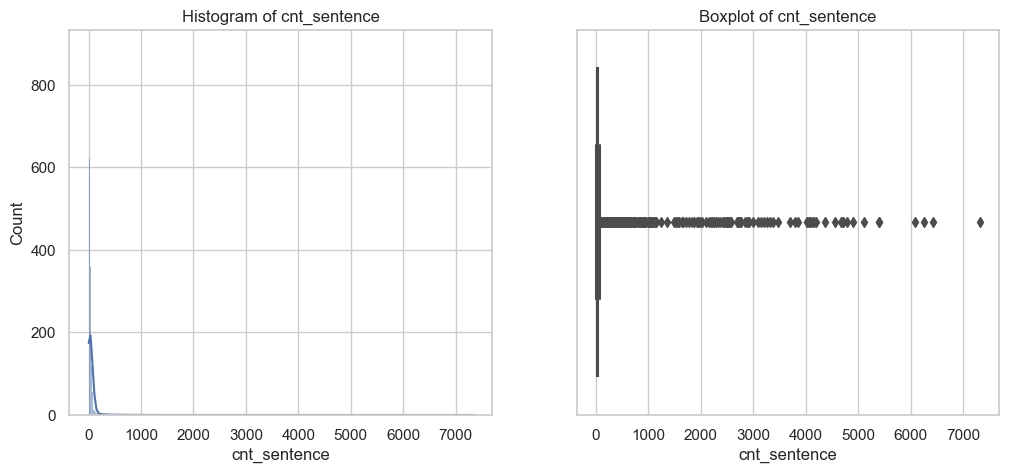

In [563]:
calculate_basic_statistical_properties('cnt_sentence', cleaned_data)
calulate_dispersion_measures('cnt_sentence', cleaned_data)
plot_basic_hist_and_box('cnt_sentence', cleaned_data)

The overall word count in the documents is heavily left-skewed and there are a huge amount of outliers according to the boxplot. Obvisouly this is also reflected in the sentence count.

Mean: 42371.97
Median: 37805.0
Mode: 2289
Skewness: 0.69
Kurtosis: -0.1
Range: 120133
Interquartile Range: 32354.0
Variance: 732176035.97
Standard Deviation: 27058.75


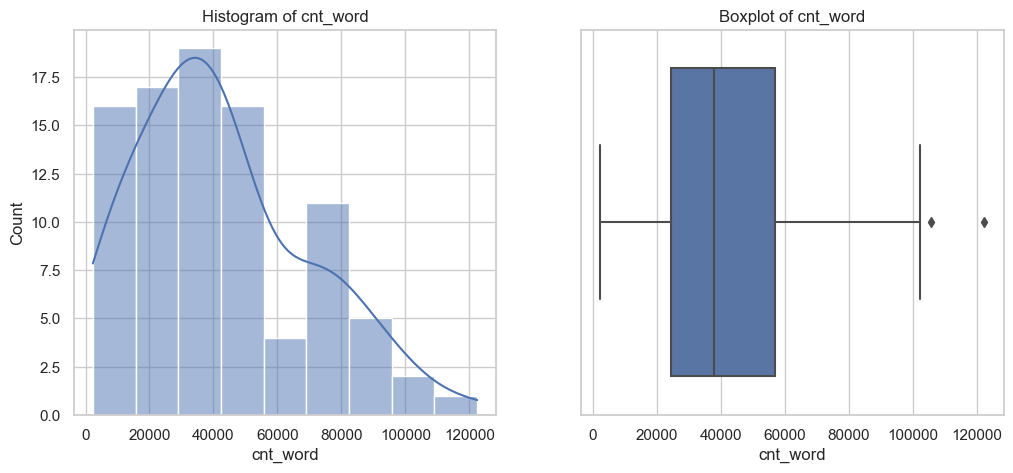

In [601]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 1])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 1])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 1])

Mean: 569.71
Median: 326.0
Mode: 257
Skewness: 17.63
Kurtosis: 451.11
Range: 60492
Interquartile Range: 319.0
Variance: 2628899.94
Standard Deviation: 1621.39


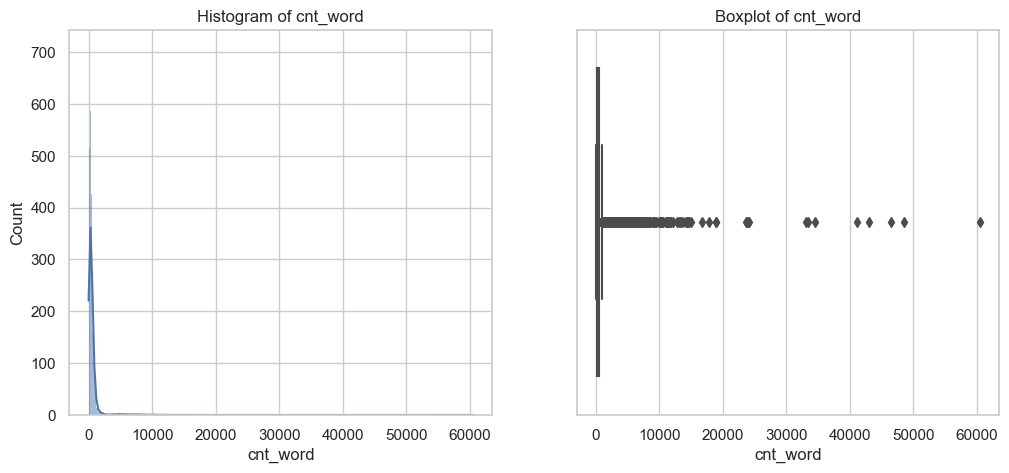

In [600]:
calculate_basic_statistical_properties('cnt_word', cleaned_data[cleaned_data.internal == 0])
calulate_dispersion_measures('cnt_word', cleaned_data[cleaned_data.internal == 0])
plot_basic_hist_and_box('cnt_word', cleaned_data[cleaned_data.internal == 0])

In the comparison of the word count between interal and external documents can be observed, that internal documents are longer and also more standardized in terms of word length.  
Also the ratio between internal and external documents is extremly imbalanced, there are much more external documents.

Mean: 3.48
Median: 2.0
Mode: 1
Skewness: 10.06
Kurtosis: 116.02
Range: 135
Interquartile Range: 3.0
Variance: 58.99
Standard Deviation: 7.68


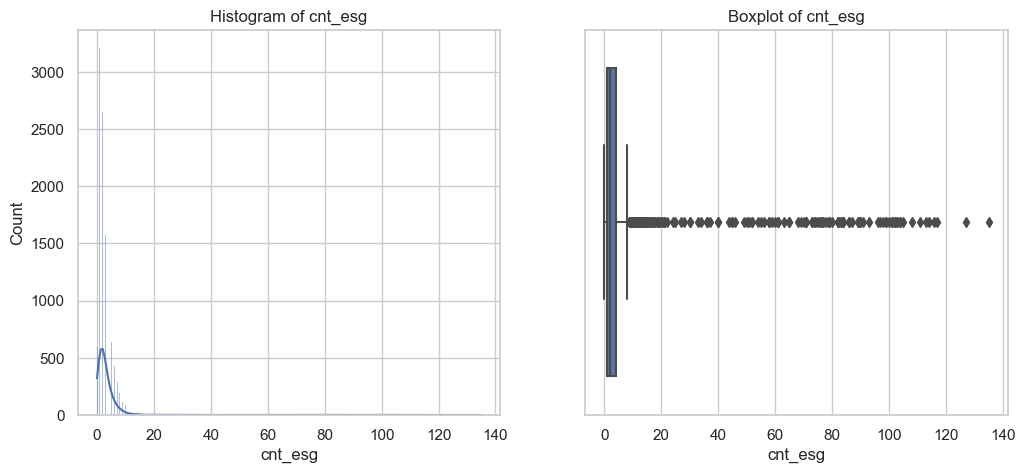

In [604]:
calculate_basic_statistical_properties('cnt_esg', cleaned_data)
calulate_dispersion_measures('cnt_esg', cleaned_data)
plot_basic_hist_and_box('cnt_esg', cleaned_data)

Around 3.5 ESG topics are mentioned in the documents. There is also an extreme left-skeness visible. 

Mean: 76.41
Median: 79.0
Mode: 79
Skewness: -0.35
Kurtosis: -0.39
Range: 106
Interquartile Range: 31.5
Variance: 536.44
Standard Deviation: 23.16


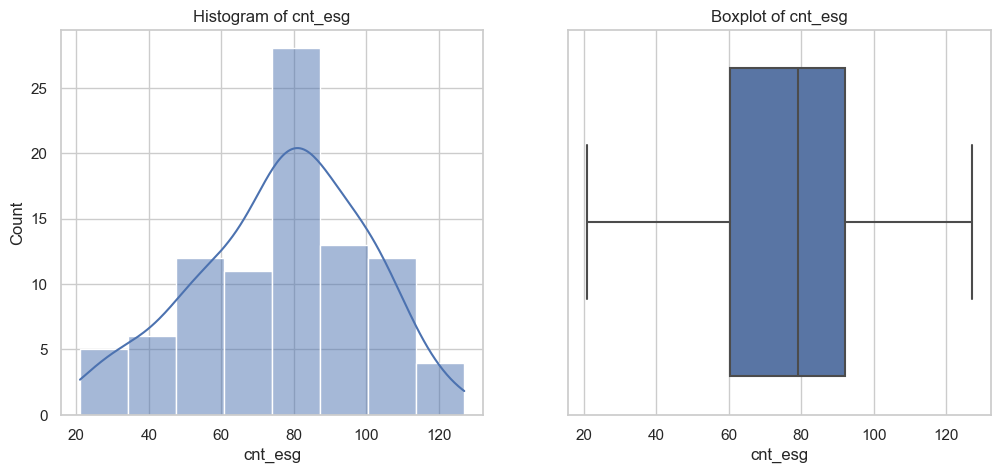

In [606]:
calculate_basic_statistical_properties('cnt_esg', cleaned_data[cleaned_data.internal == 1])
calulate_dispersion_measures('cnt_esg', cleaned_data[cleaned_data.internal == 1])
plot_basic_hist_and_box('cnt_esg', cleaned_data[cleaned_data.internal == 1])

Mean: 2.87
Median: 2.0
Mode: 1
Skewness: 13.6
Kurtosis: 422.7
Range: 135
Interquartile Range: 3.0
Variance: 10.64
Standard Deviation: 3.26


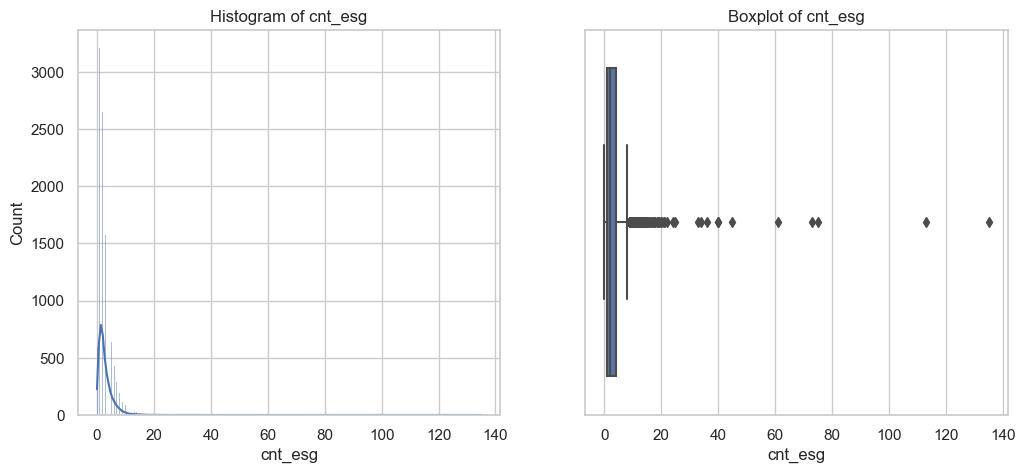

In [607]:
calculate_basic_statistical_properties('cnt_esg', cleaned_data[cleaned_data.internal == 0])
calulate_dispersion_measures('cnt_esg', cleaned_data[cleaned_data.internal == 0])
plot_basic_hist_and_box('cnt_esg', cleaned_data[cleaned_data.internal == 0])

A comparision of the mentioned ESG topics shows that, in interal documents are around 76 ESG topics mentioned. In external documents around 3. Since the internal documents are longer, I assume the mentioning of ESG topics correlates with the report length simply because of their length.

# Text Specific Analysis

### Datatype (Report Type) Amount

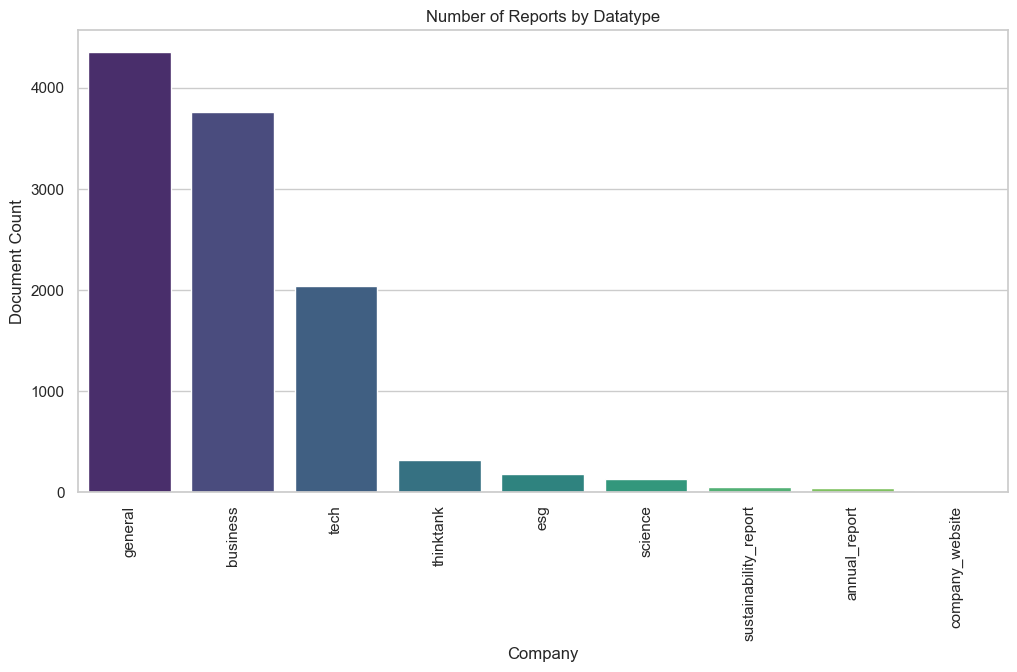

In [566]:
count_datatype = cleaned_data['datatype'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette='viridis')
plt.title('Number of documents by Datatype')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)
plt.show()

Most of the documents are general documents, followed by business and tech documents. Afterward a huge drop in terms of occurance can be observed.

### Number of documents by Company, Sector and Industry

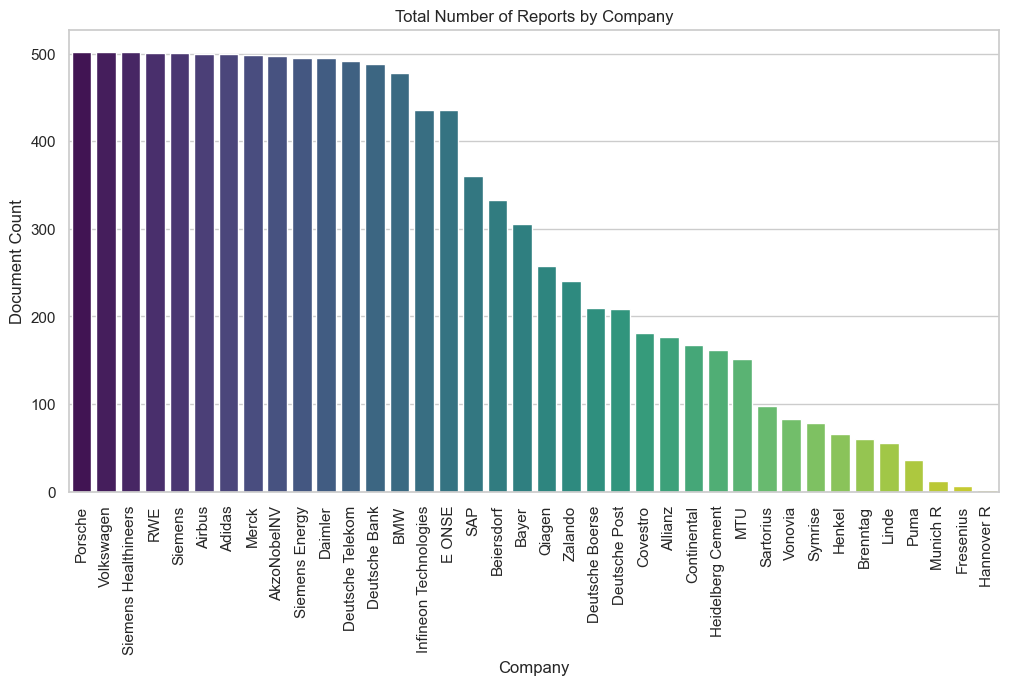

In [567]:
count_datatype = cleaned_data['company'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_datatype.index, y=count_datatype.values, palette='viridis')
plt.title('Total Number of documents by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)
plt.show()

Around 6'000 documents are from 12 companies (Porsche, Volkswagen, Siemens Healthcare, RWE, Siemens, Airbus, Adidas, Merck, AkzoNonelINV, Siemens Energy, Daimler, Deutsche Bank and BMW).  
In total there are 38 companies and around 11'000 documents. Therefore more than 50% the documents are collected from less than 33% of the companies.

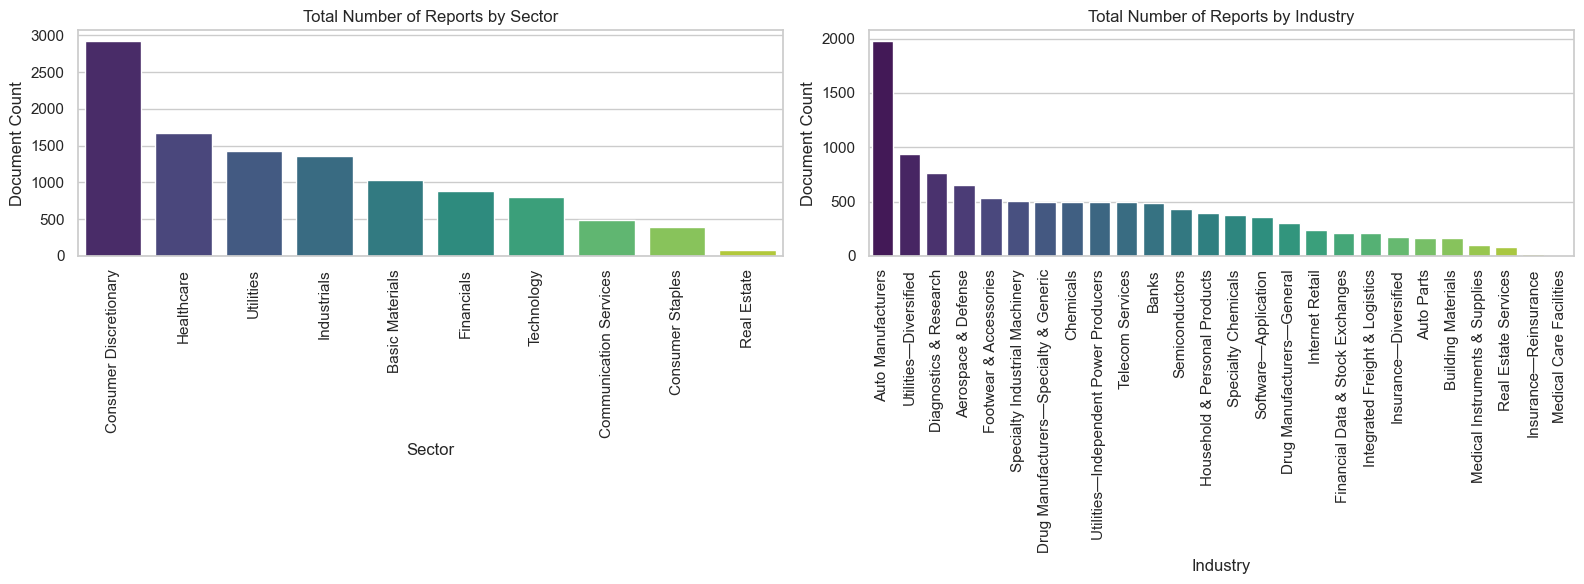

In [608]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Total Number of documents by Company
count_company = cleaned_data['sector'].value_counts()
sns.barplot(x=count_company.index, y=count_company.values, palette='viridis', ax=axes[0])
axes[0].set_title('Total Number of documents by Sector')
axes[0].set_xlabel('Sector')
axes[0].set_ylabel('Document Count')
axes[0].tick_params(axis='x', rotation=90)

# Total Number of documents by Industry
count_industry = cleaned_data['industry'].value_counts()
sns.barplot(x=count_industry.index, y=count_industry.values, palette='viridis', ax=axes[1])
axes[1].set_title('Total Number of documents by Industry')
axes[1].set_xlabel('Industry')
axes[1].set_ylabel('Document Count')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In terms of sectors, most documents are collected from companies in the Consumer Discretionary sector and the Auto Manufacturers industry.

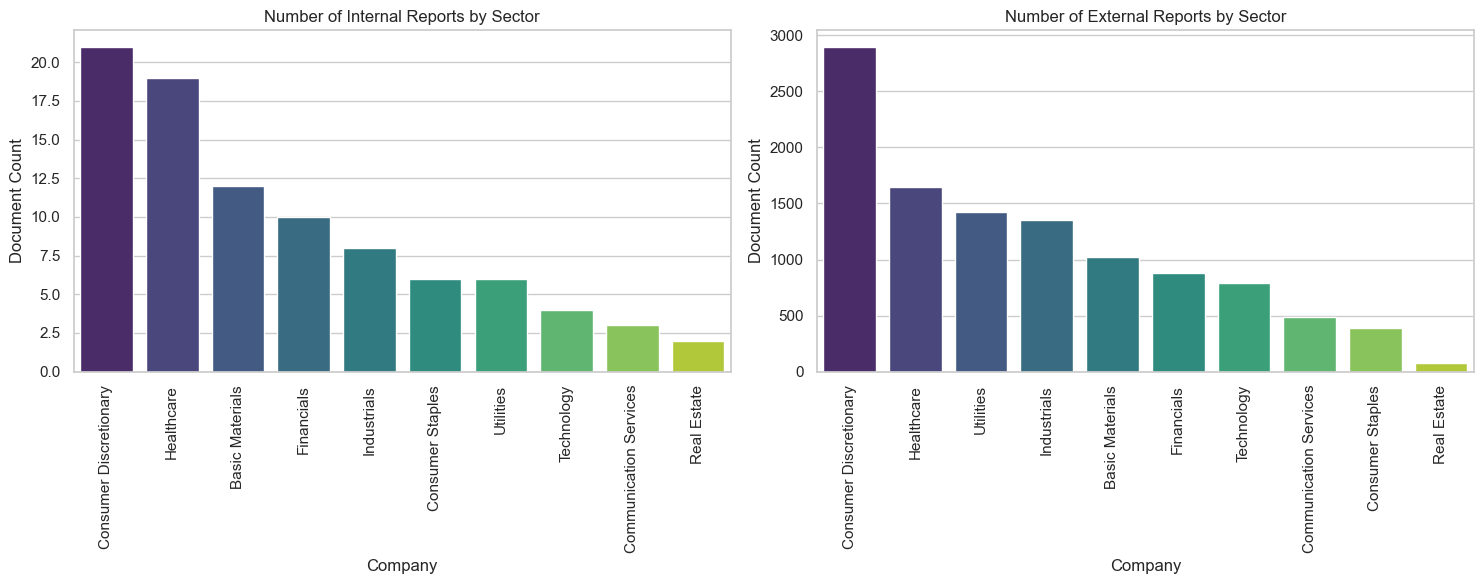

In [609]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data['sector'].value_counts()
count_external_datatype = external_data['sector'].value_counts()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=count_internal_datatype.index, y=count_internal_datatype.values, palette='viridis')
plt.title('Number of Internal documents by Sector')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x=count_external_datatype.index, y=count_external_datatype.values, palette='viridis')
plt.title('Number of External documents by Sector')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The sectors with the most/fewest documents are showing no difference in terms of the placement (top/end). The other sectors shift places and therefore a different amount of documents by sector is collected.

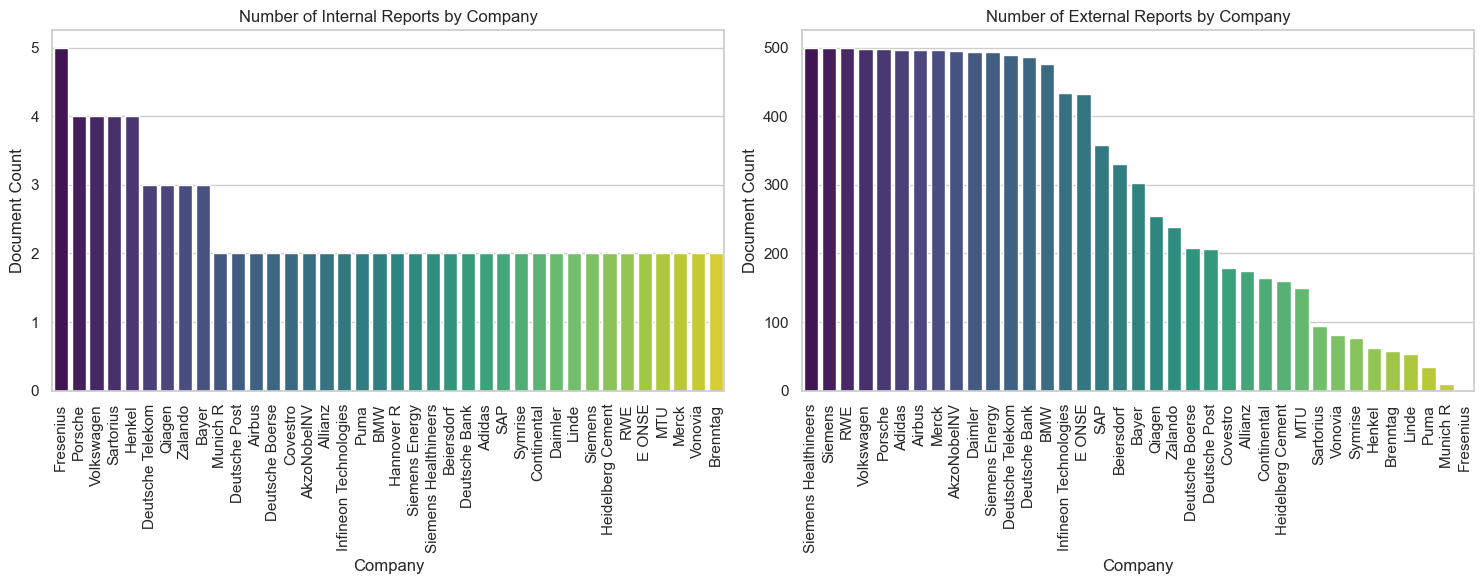

In [570]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data['company'].value_counts()
count_external_datatype = external_data['company'].value_counts()

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=count_internal_datatype.index, y=count_internal_datatype.values, palette='viridis')
plt.title('Number of Internal documents by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(x=count_external_datatype.index, y=count_external_datatype.values, palette='viridis')
plt.title('Number of External documents by Company')
plt.xlabel('Company')
plt.ylabel('Document Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The difference between internal/external documents is huge. It can be seen that for most of the companies only 2 internal documents are collected.

## Internal vs. External Report

Since the external/internal report count is quite interesting, a deeper look into this fact is conducted.

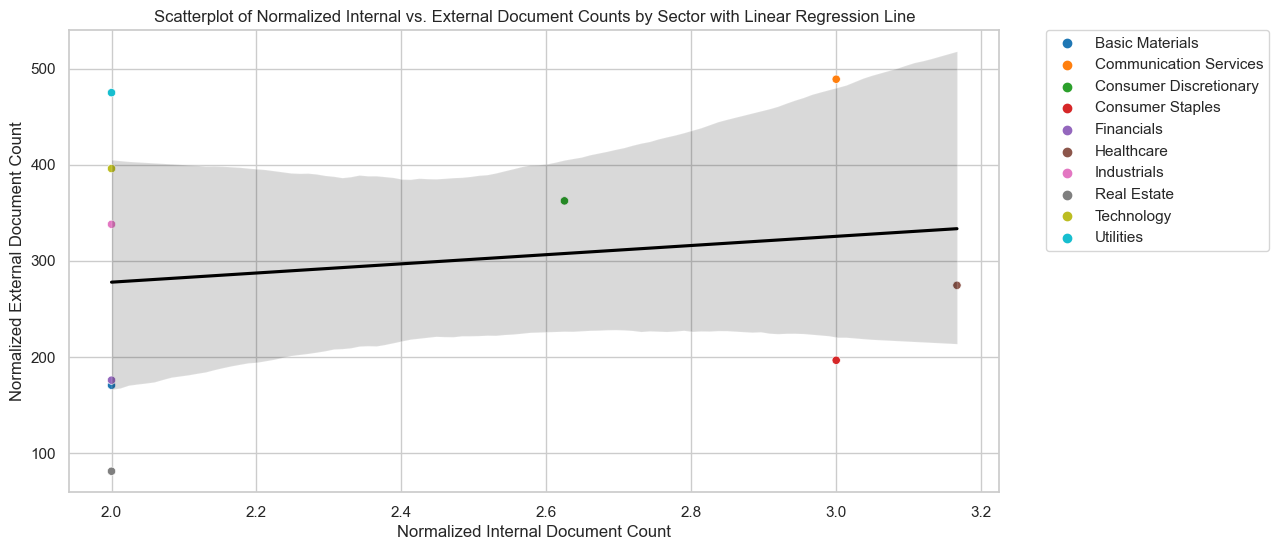

In [612]:
internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

count_internal_datatype = internal_data.groupby('sector')['company'].count()
count_external_datatype = external_data.groupby('sector')['company'].count()

doc_counts = pd.DataFrame({'internal_count': count_internal_datatype, 'external_count': count_external_datatype})
doc_counts = doc_counts.reset_index()

# Since the companies in the sectors are not evenly distributed, a normalization is used to respect the different company amount by sector
company_count_by_sector = cleaned_data.groupby('sector')['company'].nunique()
doc_counts['internal_normalized'] = doc_counts['internal_count'] / company_count_by_sector.values
doc_counts['external_normalized'] = doc_counts['external_count'] / company_count_by_sector.values

plt.figure(figsize=(12, 6))
sns.scatterplot(data=doc_counts, x='internal_normalized', y='external_normalized', hue='sector', palette='tab10')
sns.regplot(data=doc_counts, x='internal_normalized', y='external_normalized', scatter=False, color='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Scatterplot of Normalized Internal vs. External Document Counts by Sector with Regression Line')
plt.xlabel('Normalized Internal Document Count')
plt.ylabel('Normalized External Document Count')
plt.show()


In the scatterplot can be observed, there is a slight positive correlation between collected internal and external documents.

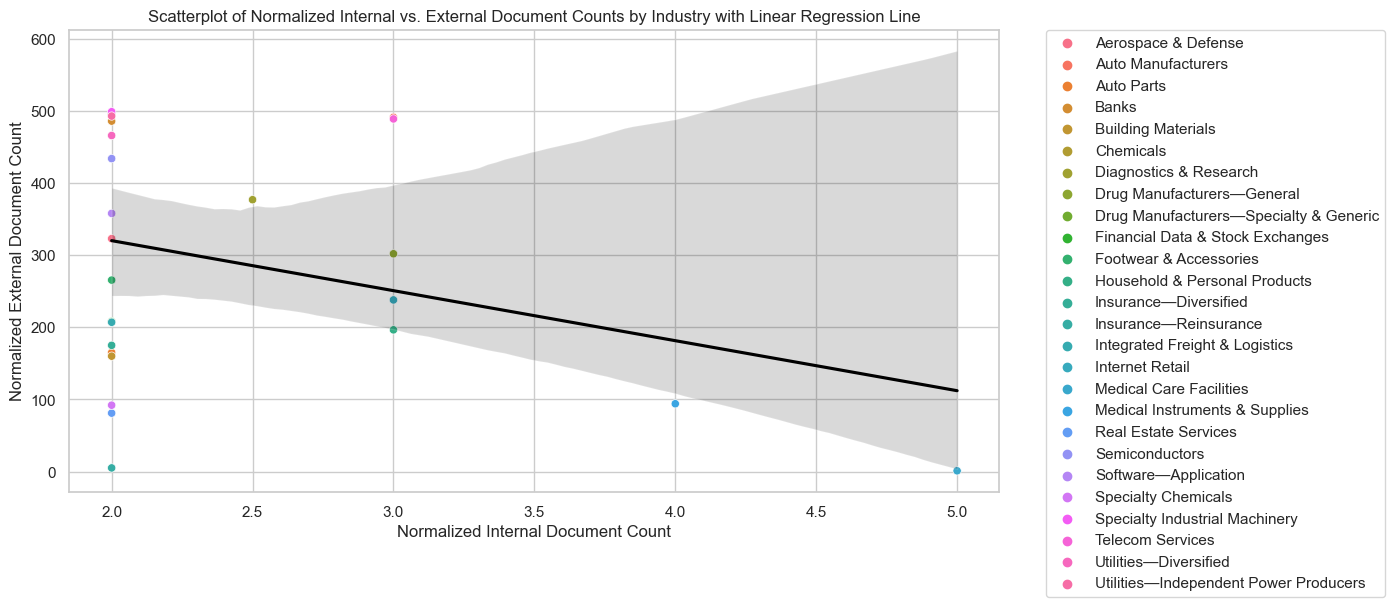

In [617]:
# Define custom color palette to account for the 26 datapoints
palette = sns.color_palette("husl", 26)

internal_data = cleaned_data[cleaned_data['internal'] == 1]
external_data = cleaned_data[cleaned_data['internal'] == 0]

# Calculate value counts for each subset
count_internal_datatype = internal_data['industry'].value_counts()
count_external_datatype = external_data['industry'].value_counts()

# Create a new DataFrame with internal and external document counts for each company
doc_counts = pd.DataFrame({'internal_count': count_internal_datatype, 'external_count': count_external_datatype})
doc_counts = doc_counts.reset_index().rename(columns={'index': 'industry'})

# Since the companies in the industries are not evenly distributed, a normalization is used to respect the different company amount by industry
company_count_by_industry = cleaned_data.groupby('industry')['company'].nunique()
doc_counts['internal_normalized'] = doc_counts['internal_count'] / company_count_by_industry.values
doc_counts['external_normalized'] = doc_counts['external_count'] / company_count_by_industry.values

plt.figure(figsize=(12, 6))
sns.scatterplot(data=doc_counts, x='internal_normalized', y='external_normalized', hue='industry', palette=palette)
sns.regplot(data=doc_counts, x='internal_normalized', y='external_normalized', scatter=False, color='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Scatterplot of Normalized Internal vs. External Document Counts by Industry with Linear Regression Line')
plt.xlabel('Normalized Internal Document Count')
plt.ylabel('Normalized External Document Count')
plt.show()

The industries Medical Care Facilities and Medical Instruments & Supplies are showing a negative correlation of the collected internal/external documents.  
Therefore I assume, companies within these industries are less likely to communicate (few internal documents provided) but are mentioned in external documents.

### Characteristic Words by Company (TFIDF)

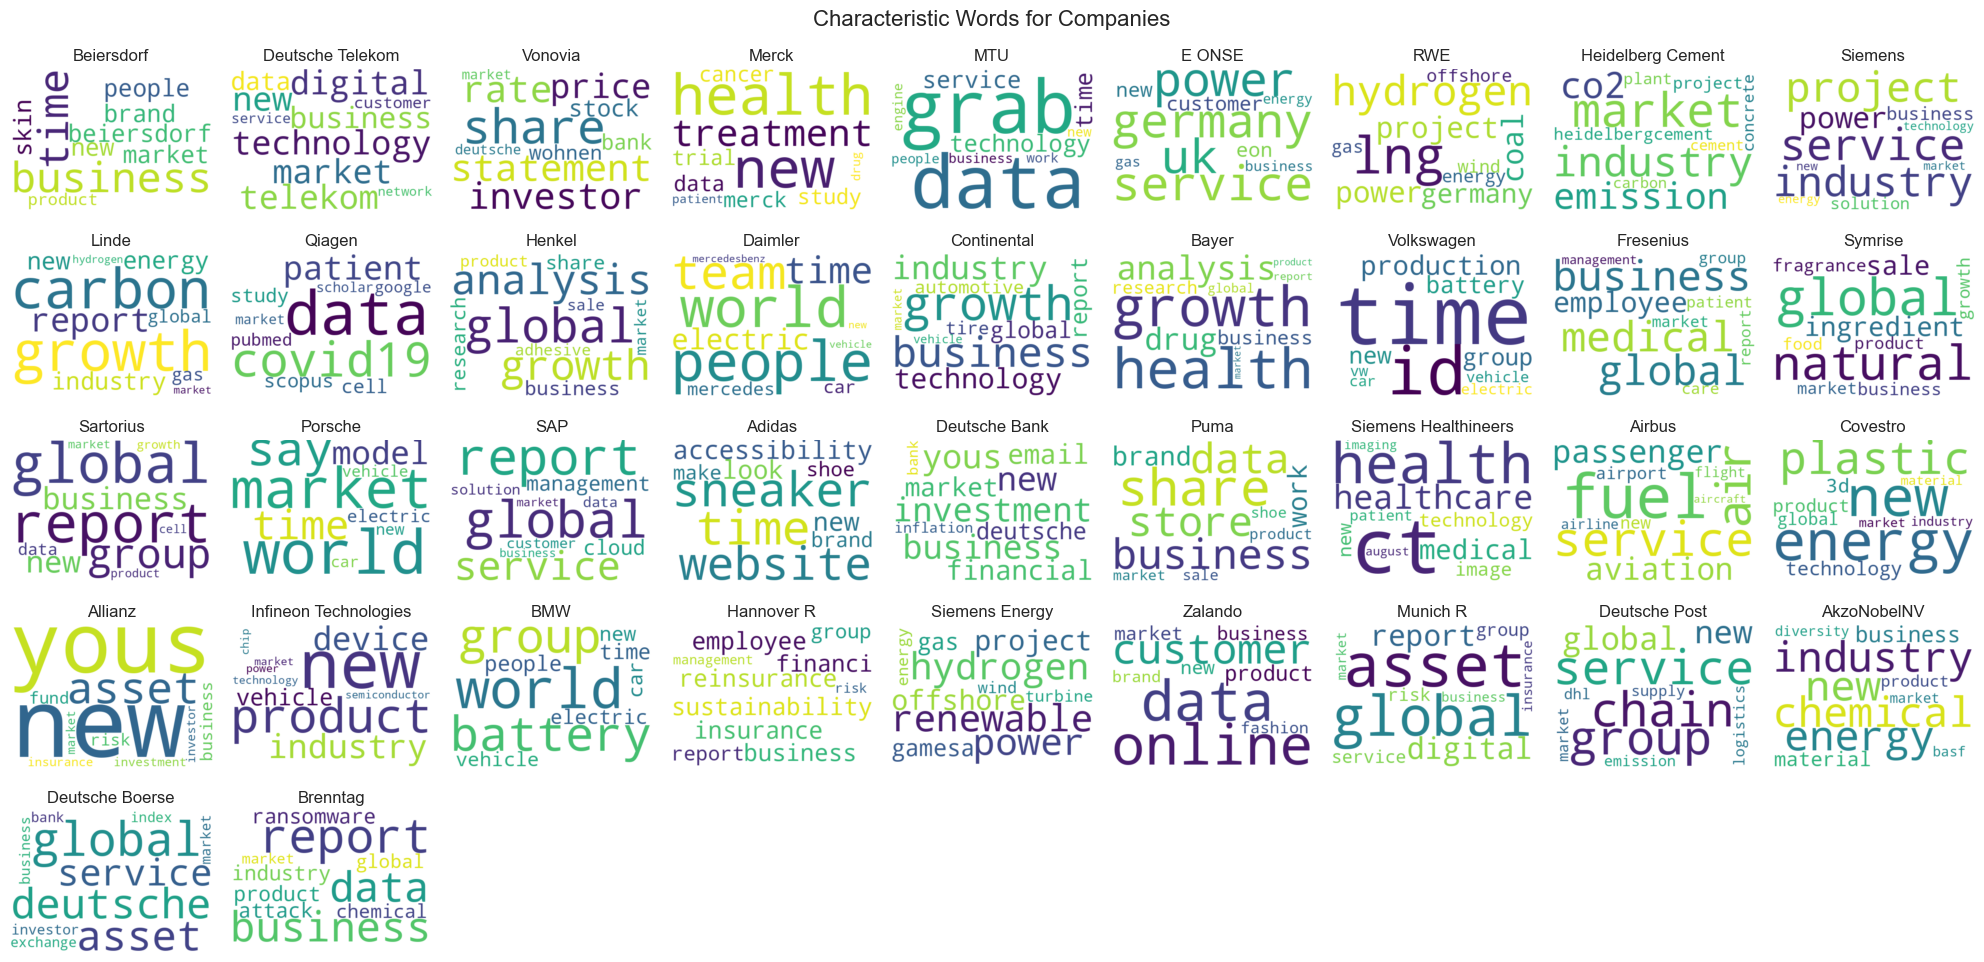

In [573]:
def characteristic_words_by_company(company, data, n=10):
    """
    Returns the top n characteristic words for a given company based on the tf-idf score of the cleaned content of the
    documents in the data DataFrame.

    Args:
    - company (str): the name of the company
    - data (pandas DataFrame): a DataFrame containing the cleaned content of the documents
    - n (int): the number of characteristic words to return (default 10)

    Returns:
    - top_n_words (numpy array): an array of length n containing the top n characteristic words
    """

    company_data = data[data['company'] == company]
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
    X = vectorizer.fit_transform(company_data['cleaned_content'])
    top_n_indices = np.argsort(X.toarray().sum(axis=0))[-n:]
    top_n_words = np.array(vectorizer.get_feature_names_out())[top_n_indices]
    return top_n_words

companies = cleaned_data['company'].unique()
for company in companies:
    characteristic_words = characteristic_words_by_company(company, cleaned_data)
    # print(f'{company}: {', '.join(characteristic_words)}')

def plot_wordcloud_subplot(ax, company, data, n=10):
    """
    Plots a wordcloud of the top n characteristic words for a given company on the given axes.

    Args:
    - ax (matplotlib.axes.Axes): the axes on which to plot the wordcloud
    - company (str): the name of the company
    - data (pandas DataFrame): a DataFrame containing the cleaned content of the documents
    - n (int): the number of characteristic words to plot (default 10)
    """
    
    characteristic_words = characteristic_words_by_company(company, data, n)
    wordcloud = WordCloud(width=500, height=350, background_color='white', colormap='viridis').generate(' '.join(characteristic_words))
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{company}')

companies = cleaned_data['company'].unique()
n_companies = len(companies)

fig, axes = plt.subplots(nrows=int(np.ceil(n_companies/9)), ncols=9, figsize=(20, 10))
axes = axes.ravel()

for i, company in enumerate(companies):
    plot_wordcloud_subplot(axes[i], company, cleaned_data)

for i in range(n_companies, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Characteristic Words for Companies', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

The Wordcloud allows a good overview of the companies and tendencies. E.g. for BMW "battery" and "electric" or Zalando "online" and "product" is calculated by TFIDF.  
In addition it indicates a rather good quality of the preprocessing and cleaning, since no e.g. no stopwords are derived from the data.

# Timeseries Analysis

For faster analysis of data over time, a timeseries plotting function is defined to get more flexibility and faster insights.

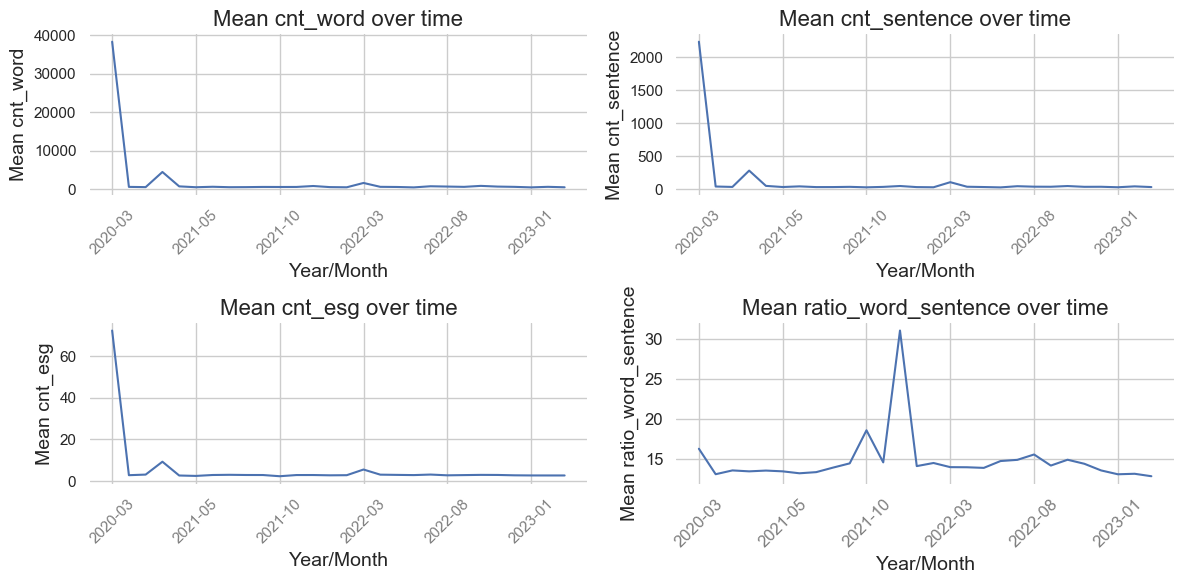

In [574]:
sns.set(style='whitegrid')

def plot_time_series(data, column, groupby_column=None, title=None, ylabel=None, start='2020-03', end='2023-03', agg_func=np.mean, ax=None, show=True):
    """Plot a time series graph for the given data column(s).
    
    Args:
    - data: DataFrame, the data containing the columns to be plotted
    - column: str or list of str, the column(s) to be plotted
    - groupby_column: str, the column to group the data by (optional)
    - title: str, the title of the plot (optional)
    - ylabel: str, the label for the y-axis (optional)
    - start: str, the start date for the plot (default is '2020-03')
    - end: str, the end date for the plot (default is '2023-03')
    - agg_func: function, the aggregation function to be applied (default is np.mean)
    - ax: matplotlib.axes.Axes, the axes to plot onto (optional)
    - show: bool, whether to show the plot (default is True)
    
    Returns:
    - None
    """
    
    # Filter data based on the start and end dates
    if start:
        data = data[data['year_month'] >= start]
    if end:
        data = data[data['year_month'] <= end]

    if groupby_column:
        grouped_data = data.groupby(['year_month', groupby_column])[column].agg(agg_func).unstack()
        ax = grouped_data.plot(ax=ax, figsize=(12, 6))
        ax.legend(title=groupby_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        grouped_data = data.groupby('year_month')[column].agg(agg_func)
        ax = grouped_data.plot(ax=ax, figsize=(12, 6))

    # Customize the plot aesthetics
    ax.set_title(title or f'{agg_func.__name__.capitalize()} {column} over time', fontsize=16)
    ax.set_xlabel('Year/Month', fontsize=14)
    ax.set_ylabel(ylabel or f'{agg_func.__name__.capitalize()} {column}', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_color('grey')
    plt.yticks(fontsize=12)
    sns.despine(left=True, bottom=True)

    if show:
        plt.tight_layout()
        plt.show()


fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plot_time_series(cleaned_data, 'cnt_word', ax=axes[0, 0], show=False)
plot_time_series(cleaned_data, 'cnt_sentence', ax=axes[0, 1], show=False)
plot_time_series(cleaned_data, 'cnt_esg', ax=axes[1, 0], show=False)
plot_time_series(cleaned_data, 'ratio_word_sentence', ax=axes[1, 1], show=False)
# plot_time_series(cleaned_data, 'cnt_word', start=start_date, end=end_date, agg_func=np.sum, ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

At the beginning of the document collection the word count is quite high and drops then to around 1000 words per document with a few outlier months / small spikes.

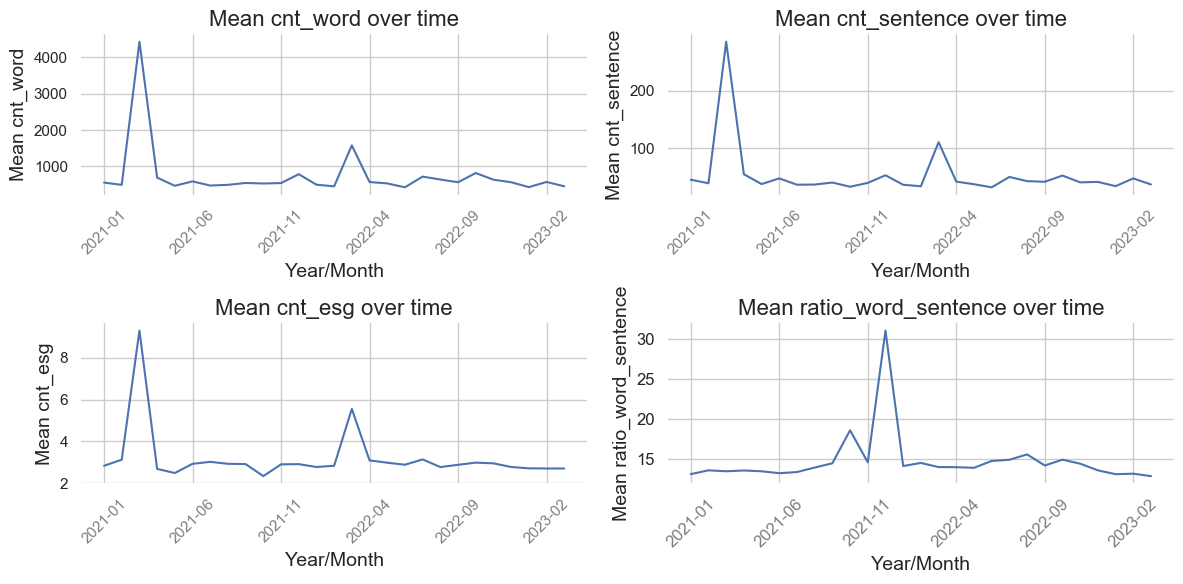

In [575]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

plot_time_series(cleaned_data, 'cnt_word', start='2020-05', ax=axes[0, 0], show=False)
plot_time_series(cleaned_data, 'cnt_sentence', start='2020-05', ax=axes[0, 1], show=False)
plot_time_series(cleaned_data, 'cnt_esg', start='2020-05', ax=axes[1, 0], show=False)
plot_time_series(cleaned_data, 'ratio_word_sentence', start='2020-05', ax=axes[1, 1], show=False)
# plot_time_series(cleaned_data, 'cnt_word', start=start_date, end=end_date, agg_func=np.sum, ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

If the huge spike at the beginning is filtered out, it can be obsverved that the average word count is around 600-800 words per document.  
At the beginning of 2021 and 2022, small spikes, e.g. greater word count, can be seen.

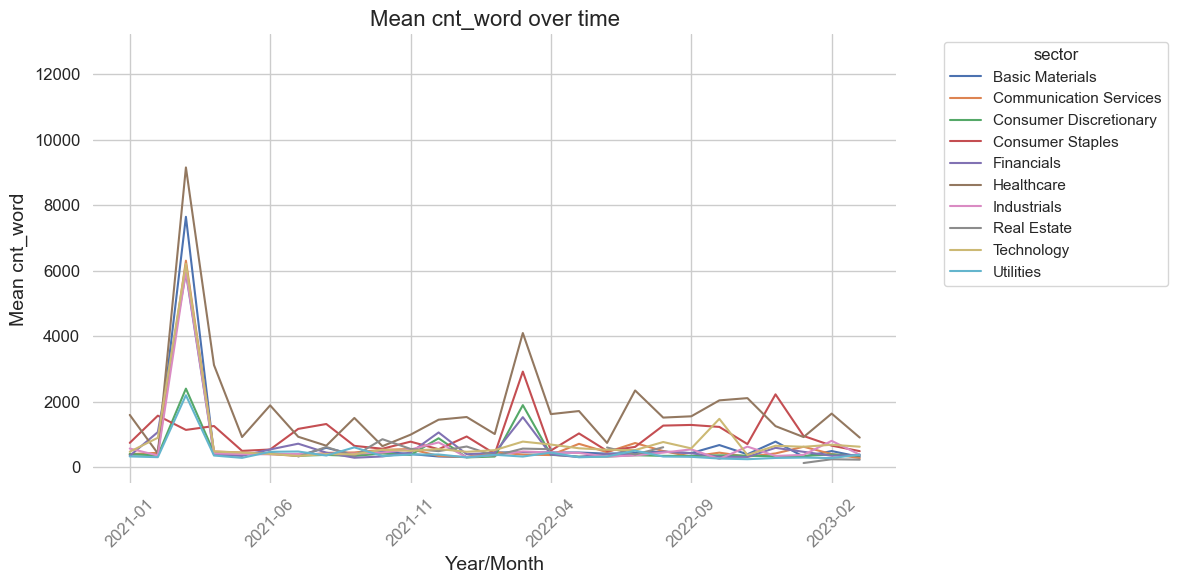

In [576]:
# Average 'cnt_word' over time by 'sector'
plot_time_series(cleaned_data, 'cnt_word', 'sector', start='2020-05',show=True)

A grouping by sector shows no pattern for different sectors.  
The same 2 spikes at the beginning of 2021 and 2022 can be obsverved.

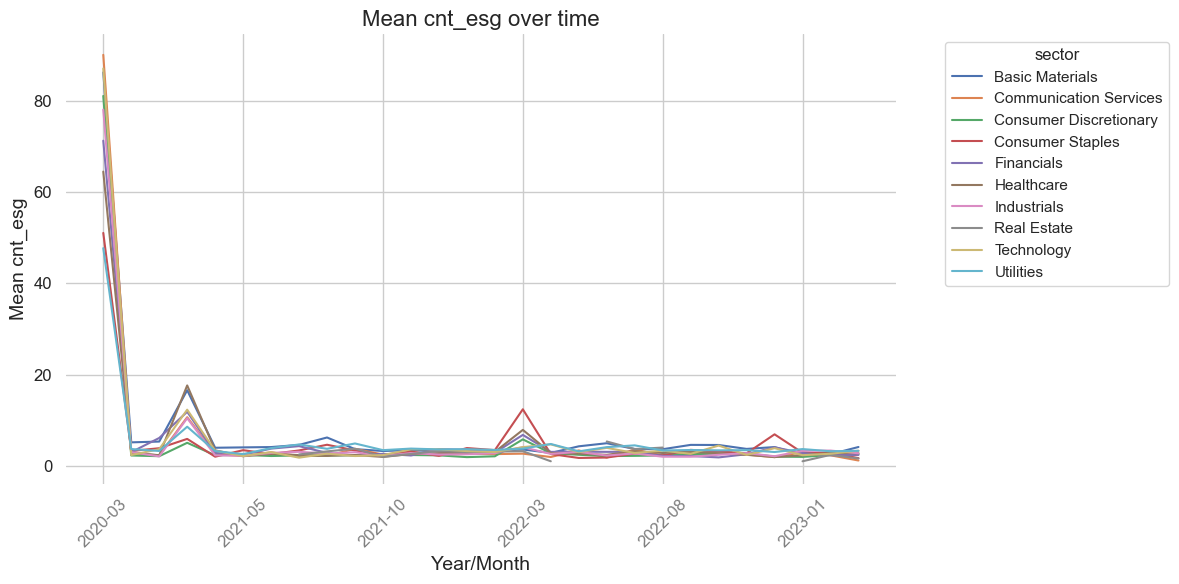

In [577]:
# Average 'cnt_esg' over time by 'sector'
plot_time_series(cleaned_data, 'cnt_esg', 'sector')

The mentioning of ESG topics seems to correlate (only visually analyzed) with the word count.  
This also confirms the assumption seen above.

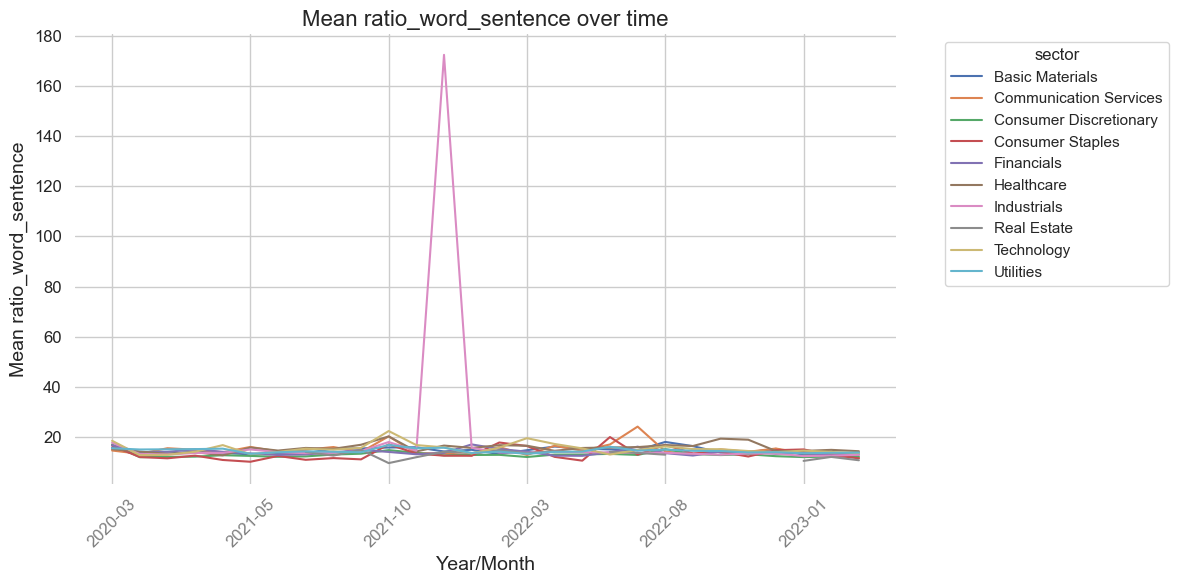

In [578]:
# Average 'ratio_word_sentence' over time by 'sector'
plot_time_series(cleaned_data, 'ratio_word_sentence', 'sector')

The ratio of words/sentences is showing no specific pattern.  
The ratio drastically increased for the Industrials sector at the end of 2021.

# Sentiment Analysis / Polarity of the documents

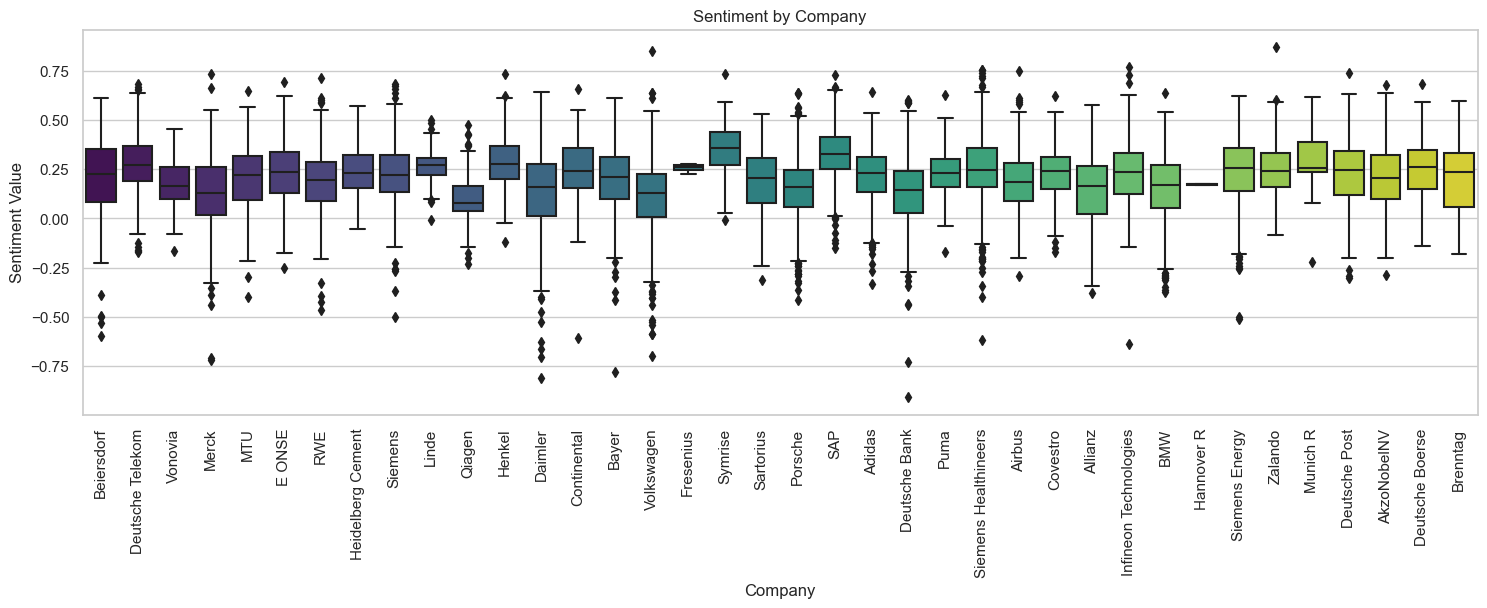

In [579]:
plt.figure(figsize=(18, 5))
sns.boxplot(data=cleaned_data, x='company', y='sentiment_value', palette='viridis')
plt.title('Sentiment by Company')
plt.xlabel('Company')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=90)
plt.show()

The sentiment of the documents by company shows a rather unbalanced picture with a tendency to more positive sentiments.  
Strong sentiment outliers can be obsverved for Deutsche Bank. Daimler and Volkswagen are showing quite a lot negative outliers.

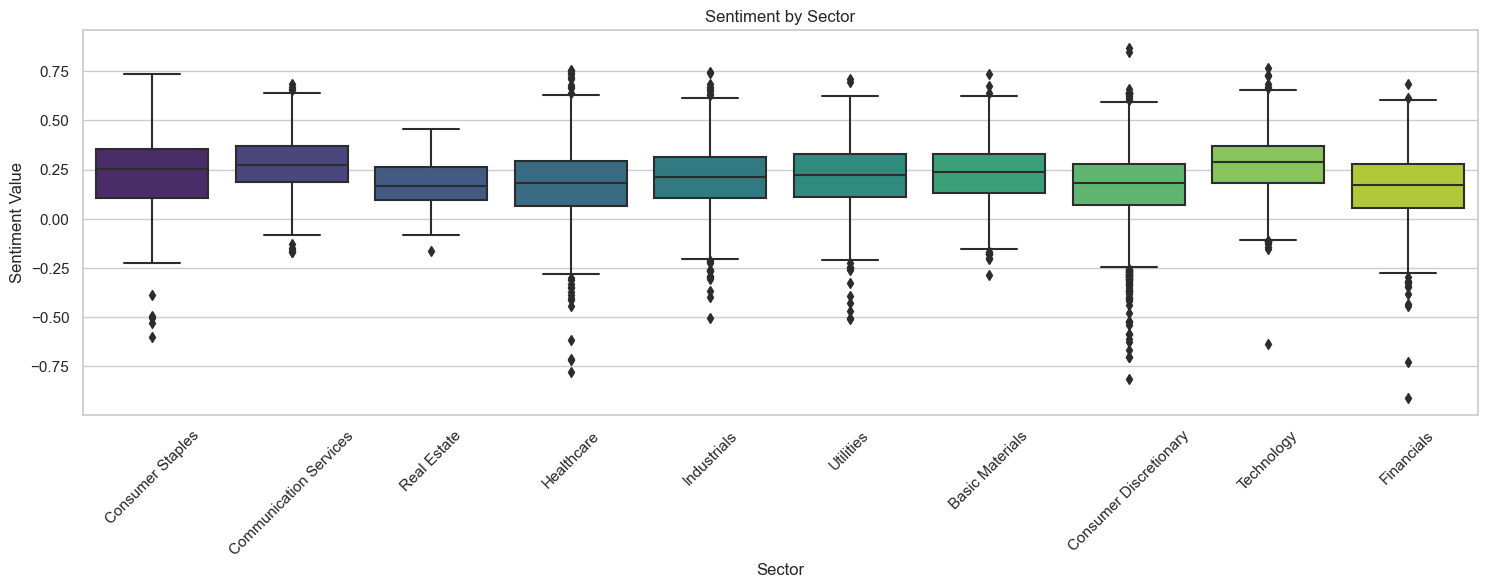

In [580]:
plt.figure(figsize=(18, 5))
sns.boxplot(data=cleaned_data, x='sector', y='sentiment_value', palette='viridis')
plt.title('Sentiment by Sector')
plt.xlabel('Sector')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=45)
plt.show()

Also the sentiment by sector is showing a rather unbalanced picture, obviously with the same tendency to a more positive sentiment.  
The sectors Healthcare and Consumer Discretionary (also includes Auto Manufacturers) are showing most of the negative outliers.

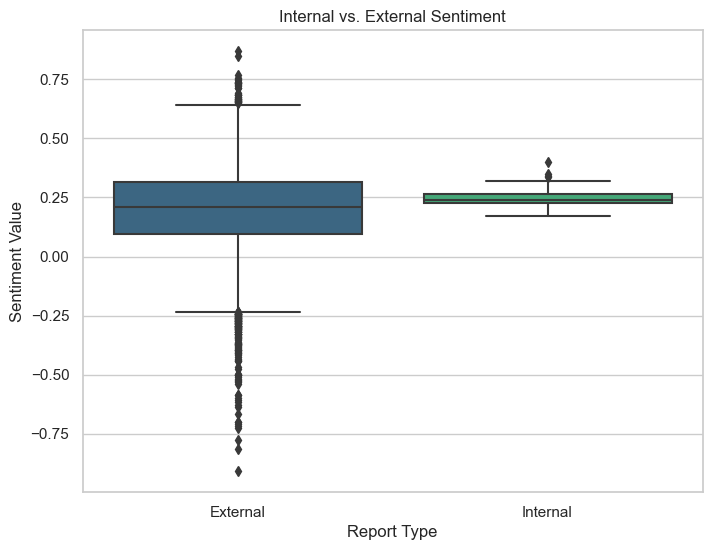

In [581]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=cleaned_data, x='internal', y='sentiment_value', palette='viridis')
plt.title('Internal vs. External Sentiment')
plt.xlabel('Report Type')
plt.ylabel('Sentiment Value')
plt.xticks([0, 1], ['External', 'Internal'])
plt.show()

The comparision of the sentiment of external / internal documents is showing an expected pattern:
- Internal documents are more standardized and therefore have a lower variance and IQR.
- External docuemnts have a higher variance and IQR, since the author is not the company itself.

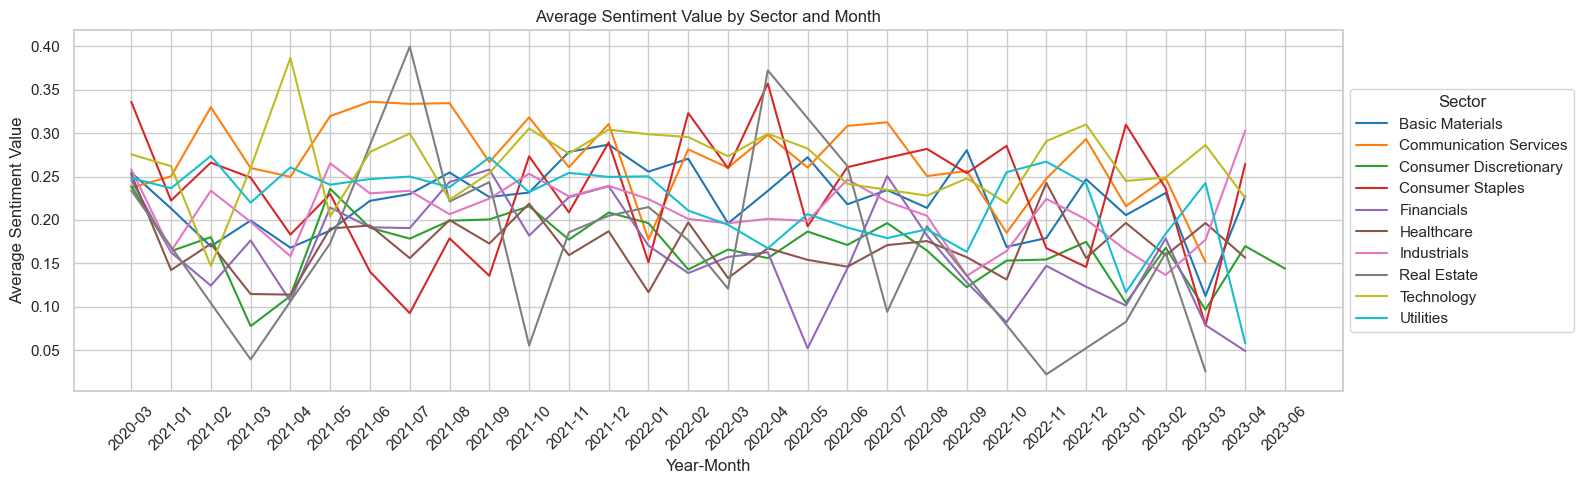

In [582]:
plt.figure(figsize=(16, 5))

# Aggregate sentiment value by sector and year_month
sentiment_by_sector_month = cleaned_data.groupby(['sector', 'year_month']).agg({'sentiment_value': 'mean'}).reset_index()

sns.lineplot(data=sentiment_by_sector_month, x='year_month', y='sentiment_value', hue='sector', palette='tab10')
plt.title('Average Sentiment Value by Sector and Month')
plt.xlabel('Year-Month')
plt.ylabel('Average Sentiment Value')
plt.xticks(rotation=45)
plt.legend(title='Sector', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The sentiment over time is showing no specific pattern.

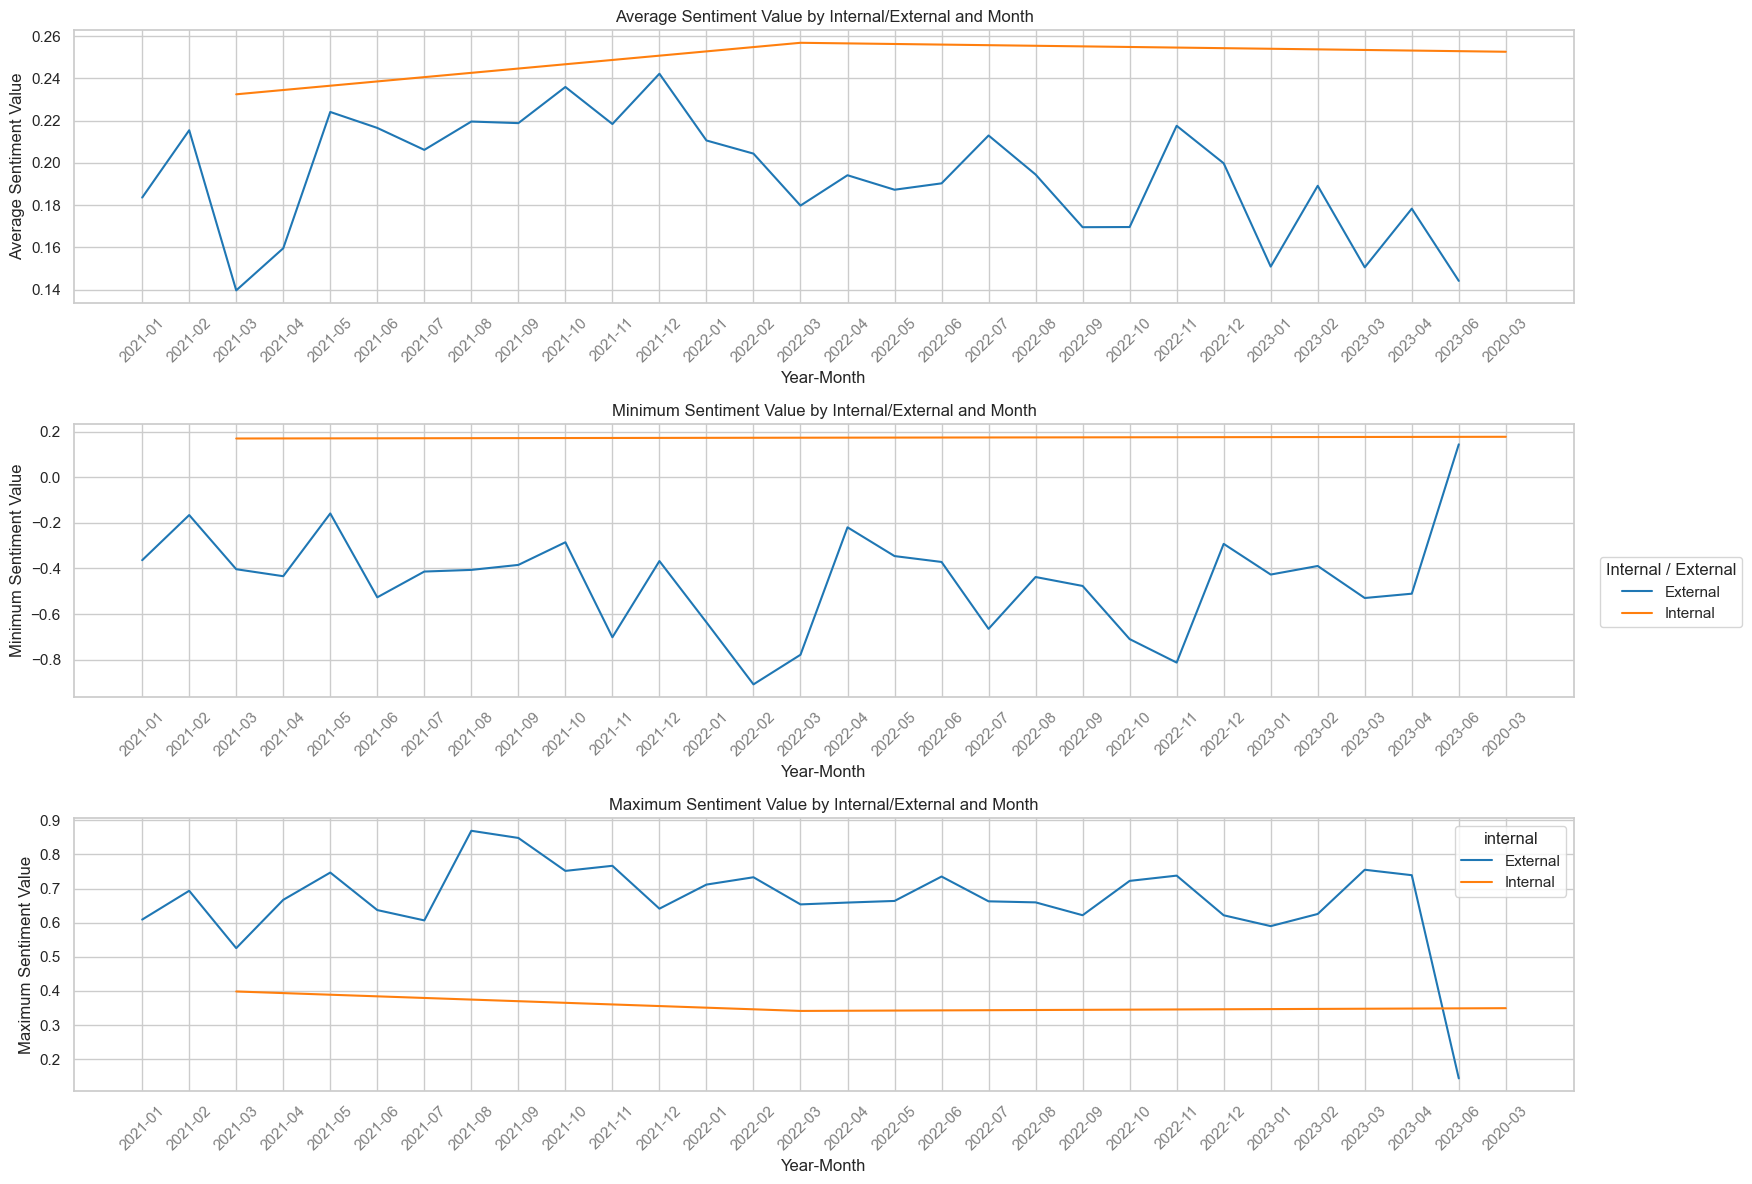

In [583]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Aggregate sentiment value by internal/external and year_month
sentiment_by_internal_month = cleaned_data.groupby(['internal', 'year_month']).agg({'sentiment_value': ['mean', 'min', 'max']}).reset_index()

# Replace internal values (0, 1) with 'External' and 'Internal'
sentiment_by_internal_month['internal'] = sentiment_by_internal_month['internal'].replace({0: 'External', 1: 'Internal'})

# Flatten the columns for easier plotting
sentiment_by_internal_month.columns = ['_'.join(col).rstrip('_') for col in sentiment_by_internal_month.columns.values]

# Plot the timeseries for average sentiment value
ax1 = sns.lineplot(ax=axes[0], data=sentiment_by_internal_month, x='year_month', y='sentiment_value_mean', hue='internal', palette='tab10', hue_order=['External', 'Internal'])
axes[0].set_title('Average Sentiment Value by Internal/External and Month')
axes[0].set_xlabel('Year-Month')
axes[0].set_ylabel('Average Sentiment Value')
axes[0].tick_params(axis='x', rotation=45, labelcolor='grey')

# Plot the timeseries for minimum sentiment value
ax2 = sns.lineplot(ax=axes[1], data=sentiment_by_internal_month, x='year_month', y='sentiment_value_min', hue='internal', palette='tab10', hue_order=['External', 'Internal'])
axes[1].set_title('Minimum Sentiment Value by Internal/External and Month')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Minimum Sentiment Value')
axes[1].tick_params(axis='x', rotation=45, labelcolor='grey')

# Plot the timeseries for maximum sentiment value
ax3 = sns.lineplot(ax=axes[2], data=sentiment_by_internal_month, x='year_month', y='sentiment_value_max', hue='internal', palette='tab10', hue_order=['External', 'Internal'])
axes[2].set_title('Maximum Sentiment Value by Internal/External and Month')
axes[2].set_xlabel('Year-Month')
axes[2].set_ylabel('Maximum Sentiment Value')
axes[2].tick_params(axis='x', rotation=45, labelcolor='grey')

# Remove the legends from the individual subplots
ax1.get_legend().remove()
ax2.get_legend().remove()

# Create a single legend for all the plots and set its position to the right side of the plot
handles, labels = ax1.get_legend_handles_labels()
legend = fig.legend(handles, labels, title='Internal / External', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

The average, max and min sentiment over time confirms the above boxplot. Internal documents are "more constant" than external documents in terms of the sentiment.

# Word Embedding Visualization with Word2Vec

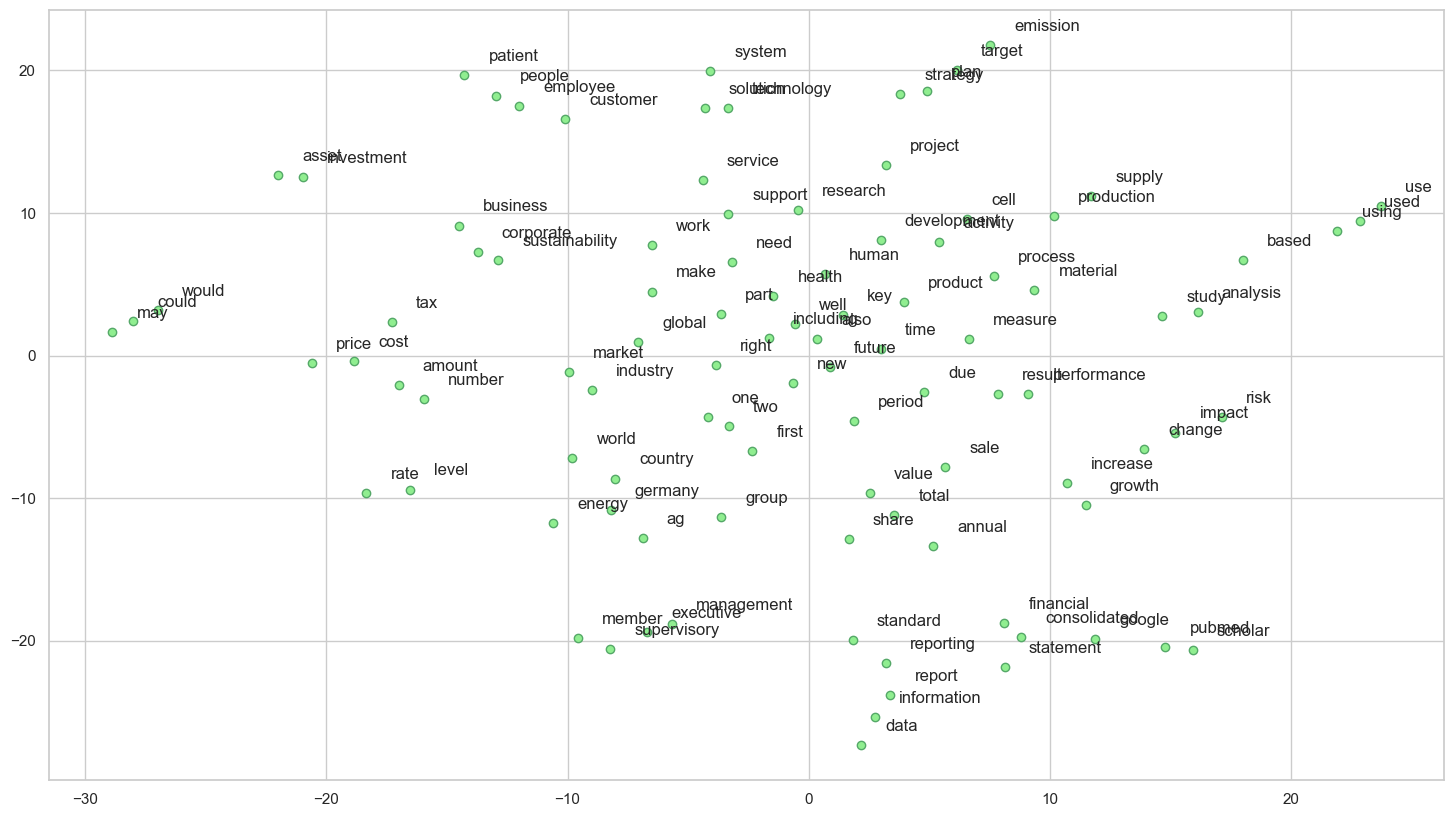

In [586]:
all_words = [word for word_list in cleaned_data['word_tokens'] for word in word_list]

# Count the occurrences of each word and find the top 100 words
word_counts = Counter(all_words)
top_100_words = [word for word, _ in word_counts.most_common(100)]

# Train a Word2Vec model on the combined words with a fixed seed (42 is always the answer)
w2vmodel = Word2Vec(cleaned_data['word_tokens'], vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Get the embeddings of the top 100 words
wvs = w2vmodel.wv[top_100_words]

# Use t-SNE to reduce the dimensions of the embeddings with a fixed seed
tsne = TSNE(n_components=2, random_state=42, n_iter=10000, perplexity=5)
T = tsne.fit_transform(wvs)
labels = top_100_words

plt.figure(figsize=(18, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

plt.show()

The clustering of the word embeddings by the Word2Vec model gives hints to underlying dataset.  
It can be obsverved that several correct clusters are calculated, which is a hint that the cleaning/preprocessing is sufficient.  
Also noise can't be obsvered anymore, which is a hint that all unnecessary word tokens are removed.

## ESG Topic Exploration

### Top X ESG Topic Distribution over Time

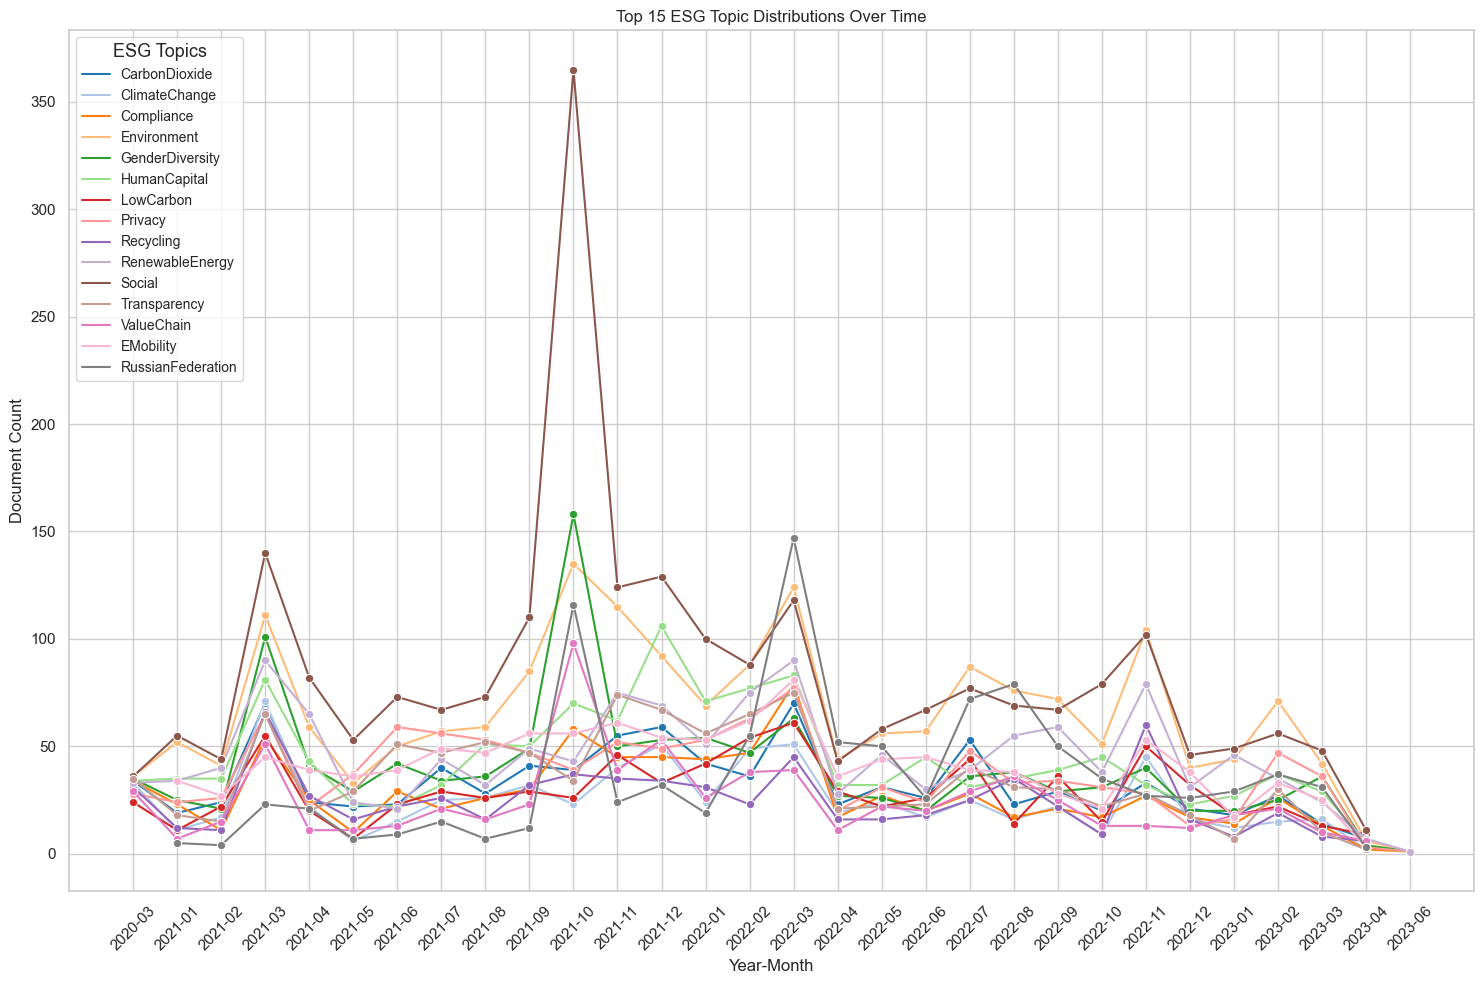

In [620]:
topic_timeseries = cleaned_data.explode('esg_topics').groupby(['year_month', 'esg_topics']).size().reset_index(name='count')

# Calculate the total count of each ESG topic
total_topic_count = topic_timeseries.groupby('esg_topics')['count'].sum().reset_index(name='total_count')

# Get the top 20 ESG topics
top_20_esg_topics = total_topic_count.nlargest(15, 'total_count')['esg_topics'].tolist()
filtered_topic_timeseries = topic_timeseries[topic_timeseries['esg_topics'].isin(top_20_esg_topics)]

plt.figure(figsize=(15, 10))
sns.lineplot(data=filtered_topic_timeseries, x='year_month', y='count', hue='esg_topics', marker='o', palette='tab20')
plt.title('Top 15 ESG Topic Distributions Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.legend(title='ESG Topics', title_fontsize='13', loc='upper left', fontsize='10')
plt.tight_layout()
plt.show()


An exploration of the mentioned ESG topics over time states, in October 2021 a lot of documents mentioned "Social". This ESG topic is also one of the most mentioned over time.  
In addition the start of the Russion war can be obsvered in February 2022.